## Build the model

The next step is to build the model by leveraging transfer learning using Inception V3. By utilizing transfer learning, we can benefit from the pre-trained weights and architecture of Inception V3, which was trained on a large-scale dataset. This approach allows us to take advantage of the learned features and patterns from Inception V3 and apply them to our specific task, maximizing the training accuracy.

Given that our dataset is not very large, we will opt for a simpler model architecture. This decision is made with good reason, as using a simpler model helps prevent overfitting and ensures better generalization to unseen data. By striking a balance between model complexity and dataset size, we aim to achieve a robust and accurate model without compromising performance.

By employing transfer learning and selecting a suitable model architecture, we set the foundation for building a powerful model that can effectively learn and classify patterns in our specific dataset. This approach saves significant computational resources and training time while still achieving impressive results.

You can examine the architecture with `model.summary()` below.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

local_weights_file = "./src/TransferLearning/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)
pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
  layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [2]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') >= 0.89:
            self.model.stop_training = True

callbacks = myCallback()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Prepare the ImageDataGenerator

We will prepare the generators for the data. We will set the training set up for data augmentation so it can mimick other poses that the model needs to learn.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

VALIDATION_DIR = "./src/Validation"
validation_datagen = ImageDataGenerator(rescale = 1./255)

TRAINING_DIR = "./src/Train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=5
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=5
)

Found 75 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


## Train the model and evaluate the results

We will train the model for approximately 50-100 epochs, leveraging the use of callbacks. The training process involves iteratively updating the model's weights based on the optimization algorithm and the provided training data. By training the model over multiple epochs, it gradually improves its ability to make accurate predictions.

During the training process, we monitor the model's performance on the validation test. The validation test evaluates the model's accuracy on a separate set of data that it has not seen during training. This allows us to assess how well the model generalizes to new, unseen data.

Once the model achieves 90% accuracy on the validation test, we will stop the training. This is achieved using a callback mechanism, which triggers a stopping condition when the desired accuracy threshold is reached. Stopping the training at this point ensures that the model has reached a satisfactory level of performance and avoids overfitting, where the model becomes too specialized to the training data and performs poorly on new data.

By stopping the training and obtaining the final result of the model, we can assess its overall performance and determine if it meets our desired criteria. This allows us to make informed decisions about the model's readiness for deployment or further improvements.



In [ ]:
# Train the model
history = model.fit(train_generator, epochs=1000, steps_per_epoch=15, validation_data = validation_generator, validation_steps=6, callbacks=[callbacks])

Epoch 1/1000
15/15 [==============================] - 6s 205ms/step - loss: 3.7875 - accuracy: 0.4000 - val_loss: 1.0851 - val_accuracy: 0.6667
Epoch 2/1000
15/15 [==============================] - 3s 232ms/step - loss: 1.1934 - accuracy: 0.5333 - val_loss: 0.6859 - val_accuracy: 0.7333
Epoch 3/1000
15/15 [==============================] - 2s 147ms/step - loss: 0.8824 - accuracy: 0.6400 - val_loss: 0.6975 - val_accuracy: 0.7333
Epoch 4/1000
15/15 [==============================] - 2s 132ms/step - loss: 0.7272 - accuracy: 0.6667 - val_loss: 0.4668 - val_accuracy: 0.8000
Epoch 5/1000
15/15 [==============================] - 2s 131ms/step - loss: 0.7805 - accuracy: 0.7333 - val_loss: 0.5284 - val_accuracy: 0.8667
Epoch 6/1000
15/15 [==============================] - 2s 134ms/step - loss: 0.5719 - accuracy: 0.8133 - val_loss: 0.5296 - val_accuracy: 0.7667
Epoch 7/1000
15/15 [==============================] - 2s 129ms/step - loss: 0.5918 - accuracy: 0.7467 - val_loss: 0.6828 - val_accuracy:

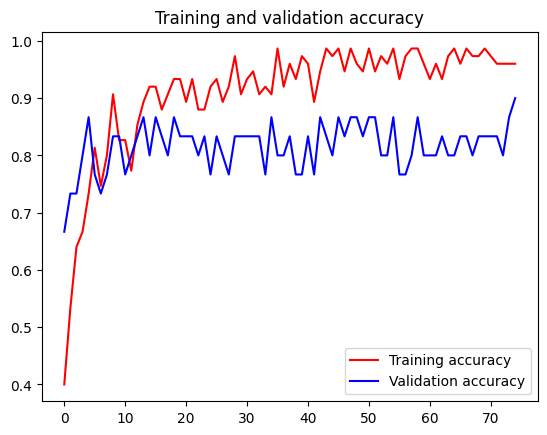

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

## Export Model
After testing the model and confirming its accuracy for the Minimum Viable Product (MVP), the next step is to export the model in both h5 and TFLite formats.

Exporting the model allows us to save its architecture, weights, and other necessary parameters in a file format that can be easily loaded and utilized for future predictions or deployment. The h5 format is a standard file format in the Keras library, which can be used to store the entire model configuration and weights.

In [4]:
from tensorflow.keras.models import load_model

# Save the model in h5 format

model.save('./model/model.h5')

In [5]:
import tensorflow as tf

loaded_model = model

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
# Save the TFLite model to a file
with open('./model/optimized_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp9w6xfge9\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp9w6xfge9\assets


In [6]:
import tensorflowjs as tfjs

#Save the model in TensorflowJS format

tfjs.converters.save_keras_model(model, './model/tfjs')

## Load Model

Once we have saved a trained model in the h5 file format, we can easily import it without the necessity of retraining the model from scratch. This means we can directly utilize the saved model to make predictions on new data, saving time and computational resources.

In [1]:
import tensorflow as tf
from tensorflow import keras
model = tf.keras.models.load_model('./model/model.h5')

In [2]:
print(tf.__version__)

2.12.0
